# Global Settings

In [ ]:
#@title GLOBAL IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from google.colab.patches import cv2_imshow
import os
import imutils
import random
import time
import shutil
from google.colab import drive
from shutil import copyfile

import torch
from IPython.display import Image  # to display images
%pip install -q wandb
import wandb
import PIL.Image

In [ ]:
#@title GLOBAL PARAMS

PARAMS = {
    'GLOBAL': {
        'aruco_folder': '/content/aruco'
    },
    'ARUCO_GEN': { # ArUco Generation Params
        'out_dir_name': 'original_aruco',
        'nr_of_aruco': 15,
        'type_of_aruco': 'DICT_4X4_1000',
        'aruco_width': 30,
        'aruco_height': 30,
        'aruco_border_size': 5 # ATT!! total dims: width=aruco_width + (2 * aruco_border_size), height=...
    },
    'ARUCO_TRANSF': { # Transformation Params
        'out_dir_name': 'edited_aruco',
        'nr_of_perspective_transfs': 3,
        'nr_of_transformations': 5,
        'reduct_fact_width_range': [0.40, 0.70],
        'reduct_fact_height_range': [0.30, 0.70],
        'range_brightness_alpha': [1, 1] , # gain (contrast control)
        'range_brightness_beta': [-40, 100], # bias (brightness control)
        'enable_aruco_occlusions': True,
        'reduce_factor_occlusions': 3
    },
    'COCO_DATASET': { # COCO Dataset Params
        'imgs_dir_name': '/content/coco/images'
    },
    'IMAGE_OVERLAY': { # Image Overlay Params
        'dataset_path': '/content/dataset',
        'labels_path': 'labels',
        'imgs_path': 'images',
        'canny_threshold1': 10,
        'canny_threshold2': 100,
        'nr_of_imgs_for_aruco': 20, # nr of COCO images for each ArUco image (each ArUco has 'nr_of_transformations' + 1 images)
        'range_images_size_width': [500, 700],
        'range_images_size_height': [500, 700],
        'disable_grayscale_imgs': True,
    },
    'DRIVE': {
        'mount_drive_dir': '/content/drive',
        'dest_dir': 'MyDrive/TestColab',
        'custom_db_yaml_path': 'MyDrive/TestColab/data/custom_db.yaml',
        'coco_db_path': 'MyDrive/TestColab/2021_07_10_07_46_COCO_DB',
        
    },
    'CUSTOM_DATABASE': {
        'database_directory': '/content/splitted_dataset',
        'perc_train': 70, # percentage of train set 
        'perc_val': 20, # percentage of val set 
        'perc_test': 10, # percentage of test set 
        'train_dir_name': 'train',
        'val_dir_name': 'val',
        'test_dir_name': 'test',


    }
}

# ArUco Generation in OpenCV

In [ ]:
#@title ArUco Generation PARAMETERS
name_of_directory = os.path.join(PARAMS['GLOBAL']['aruco_folder'], PARAMS['ARUCO_GEN']['out_dir_name'])
nr_of_aruco = PARAMS['ARUCO_GEN']['nr_of_aruco']
type_of_aruco = PARAMS['ARUCO_GEN']['type_of_aruco']
aruco_width = PARAMS['ARUCO_GEN']['aruco_width'] # in number of pixels
aruco_height = PARAMS['ARUCO_GEN']['aruco_height'] # in number of pixels
bordersize = PARAMS['ARUCO_GEN']['aruco_border_size'] # in number of pixels

## Code

In [ ]:
# define names of each possible ArUco tag OpenCV supports
ARUCO_DICT = {
	"DICT_4X4_50": cv2.aruco.DICT_4X4_50,
	"DICT_4X4_100": cv2.aruco.DICT_4X4_100,
	"DICT_4X4_250": cv2.aruco.DICT_4X4_250,
	"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
	"DICT_5X5_50": cv2.aruco.DICT_5X5_50,
	"DICT_5X5_100": cv2.aruco.DICT_5X5_100,
	"DICT_5X5_250": cv2.aruco.DICT_5X5_250,
	"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
	"DICT_6X6_50": cv2.aruco.DICT_6X6_50,
	"DICT_6X6_100": cv2.aruco.DICT_6X6_100,
	"DICT_6X6_250": cv2.aruco.DICT_6X6_250,
	"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
	"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
	"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
	"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
	"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
	"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
	"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
	"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
	"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
	"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
}

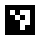

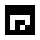

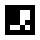

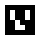

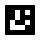

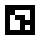

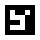

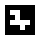

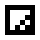

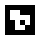

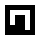

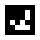

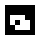

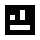

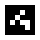

In [ ]:
# create the output directory
Path(name_of_directory).mkdir(parents=True, exist_ok=True)

# load the ArUco dictionary
arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT[type_of_aruco])

# for each ArUco to create
for arucoID in range(nr_of_aruco):
  # allocate memory for the output ArUco tag
  tag = np.zeros((aruco_width, aruco_height, 1), dtype="uint8")
  # draw the ArUco tag on the output image
  cv2.aruco.drawMarker(arucoDict, arucoID, aruco_width, tag, 1)

  # add white border
  tag = cv2.copyMakeBorder(
    tag,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255]) 
  
  # write the generated ArUco tag to disk and then print it
  cv2.imwrite(os.path.join(name_of_directory, f'aruco_{arucoID:02d}.jpg'), tag)
  cv2_imshow(tag)
  print('\n')


# All ArUco Transformations

In [ ]:
#@title OpenCV Transformations PARAMETERS
out_dir = os.path.join(PARAMS['GLOBAL']['aruco_folder'], PARAMS['ARUCO_TRANSF']['out_dir_name'])
reduct_fact_width_range = PARAMS['ARUCO_TRANSF']['reduct_fact_width_range']
reduct_fact_height_range = PARAMS['ARUCO_TRANSF']['reduct_fact_height_range']
nr_of_transf = PARAMS['ARUCO_TRANSF']['nr_of_transformations']
occlusions_enabled = PARAMS['ARUCO_TRANSF']['enable_aruco_occlusions']
red_fact_occlusions = PARAMS['ARUCO_TRANSF']['reduce_factor_occlusions']
nr_of_perspective_transfs = PARAMS['ARUCO_TRANSF']['nr_of_perspective_transfs']

## Code

In [ ]:
def perspective_transf(paper, reduct_fact_width, reduct_fact_height):
  # ArUco width and height
  paper_width, paper_height = paper.shape[:2]
  
  # set the size of the result image 
  # out_width, out_height = paper_width, paper_height #ALTERNATIVA
  out_width, out_height = paper_width + 10, paper_height + 10 # TODO

  # set the coordinates that we want to perspective transform (the coords of the whole image)
  pts1 = np.float32([[0,0], [paper_width - 1 ,0], [paper_height - 1,paper_width - 1], [0, paper_height - 1]])

  # size of the transformed image
  new_width = round(paper_width * reduct_fact_width)
  new_height = round(paper_height * reduct_fact_height)

  # top left point
  # tl_point_x = 0 #ALTERNATIVA
  # tl_point_y = 0 #ALTERNATIVA
  tl_point_x = round((out_width - paper_width)/2)
  tl_point_y = round((out_height - paper_height)/2)
  tl_point = [tl_point_x, tl_point_y]

  # top right point
  tr_point_x = tl_point_x + (paper_width - 1)
  tr_point_y = tl_point_y
  tr_point = [tr_point_x, tr_point_y]

  # bottom left point
  bl_point_x = tl_point_x + (round((paper_width - new_width) / 2)) - 1
  bl_point_y = tl_point_y + (new_height - 1)
  bl_point = [bl_point_x, bl_point_y]

  # bottom right point
  br_point_x = bl_point_x + (new_width - 1)
  br_point_y = bl_point_y
  br_point = [br_point_x, br_point_y]

  # set the coordinates of the new image
  pts2 = np.float32([tl_point, tr_point, br_point, bl_point])

  # transformation matrix
  M = cv2.getPerspectiveTransform(pts1, pts2)
  
  # transform the original image
  return cv2.warpPerspective(paper, M, (out_width, out_height))

In [ ]:
def make_transf(orig_aruco, aruco_name, nr_of_transf, out_dir, loop, index):
  # create an indipendente copy of the NumPy array
  edited_aruco = np.copy(orig_aruco)

  if nr_of_transf != 0:
    # rotation transformation
    rotation_angle = random.randrange(0, 360)
    edited_aruco = imutils.rotate_bound(edited_aruco, rotation_angle)
    # print transformed image
    plt.title(f'Rotation transformation with angle={rotation_angle}')
    plt.imshow(edited_aruco, cmap='gray')
    plt.show()
    # save the edited ArUco
    cv2.imwrite(os.path.join(out_dir, aruco_name[:-4] + '_' + f"{index:02}" + '.jpg'), edited_aruco)
    index += 1
    nr_of_transf -=1 

  if nr_of_transf != 0:
    # random enable flip vertically and horizontally 
    if bool(random.getrandbits(1)):
      edited_aruco = cv2.flip(edited_aruco, -1)
      # print transformed image
      plt.title(f'Flip vertically AND horizontally transformation')
      plt.imshow(edited_aruco, cmap='gray')
      plt.show()
      # save the edited ArUco
      cv2.imwrite(os.path.join(out_dir, aruco_name[:-4] + '_' + f"{index:02}" + '.jpg'), edited_aruco)
      index += 1
      nr_of_transf -= 1     

  return nr_of_transf, index

In [ ]:
def make_occlusion(orig_aruco):
  aruco_w, aruco_h = orig_aruco.shape[:2]
  tl_point = (0, 0)
  br_point = (aruco_w - 1, aruco_h - 1)

  def cover_left_edge(orig_aruco):
    # occlusion on left edge
    orig_aruco = cv2.rectangle(orig_aruco, tl_point, (aruco_w // red_fact_occlusions, aruco_h), (0, 0, 0), cv2.FILLED)
    plt.title(f'Occlusion on left edge')

  def cover_right_edge(orig_aruco):
    # occlusion on right edge
    orig_aruco = cv2.rectangle(orig_aruco, br_point, (br_point[0] - (aruco_w // red_fact_occlusions), 0), (0, 0, 0), cv2.FILLED)
    plt.title(f'Occlusion on right edge')

  def cover_top_edge(orig_aruco):
    # occlusion on top edge
    orig_aruco = cv2.rectangle(orig_aruco, tl_point, (aruco_w, aruco_h // red_fact_occlusions), (0, 0, 0), cv2.FILLED)
    plt.title(f'Occlusion on top edge')

  def cover_bottom_edge(orig_aruco):
    # occlusion on bottom edge
    orig_aruco = cv2.rectangle(orig_aruco, br_point, (0, (aruco_h - 1) - aruco_h // red_fact_occlusions), (0, 0, 0), cv2.FILLED)
    plt.title(f'Occlusion on bottom edge')


  options = {
          0 : cover_left_edge,
          1 : cover_right_edge,
          2 : cover_top_edge,
          3 : cover_bottom_edge
          } 
  
  # print transformed image
  options[random.randint(0, 3)](orig_aruco)

In [ ]:
# create dir
Path(out_dir).mkdir(parents=True, exist_ok=True)

# read all ArUco filenames
aruco_list = [f for f in os.listdir(name_of_directory) if os.path.isfile(os.path.join(name_of_directory,f))]

# for each ArUco filename
for aruco_name in aruco_list:
  if aruco_name != "aruco_13.jpg":
    continue
  # read the ArUco image
  original_aruco = cv2.imread(os.path.join(name_of_directory, aruco_name), cv2.IMREAD_GRAYSCALE)
  # ArUco width and height
  original_width, original_height = original_aruco.shape[:2]
  # print the original image
  plt.imshow(original_aruco, cmap='gray')
  plt.title(f'Original ArUco {aruco_name[-6:-4]}')
  plt.show()

  index = 0

  for _ in range(nr_of_perspective_transfs):
    reduct_fact_width = random.uniform(reduct_fact_width_range[0], reduct_fact_width_range[1])
    reduct_fact_height = random.uniform(reduct_fact_height_range[0], reduct_fact_height_range[1])
    # perspective transformation
    edited_aruco = perspective_transf(original_aruco, reduct_fact_width, reduct_fact_height)
    # print transformed image
    plt.title(f'Perspective transformation')
    plt.imshow(edited_aruco, cmap='gray')
    plt.show()
    # save the transformed ArUco
    cv2.imwrite(os.path.join(out_dir, aruco_name[:-4] + f'_{index:02}.jpg'), edited_aruco)

    index += 1
    residual_transf = nr_of_transf - 1

    while(True):
      # make some transformations
      residual_transf, index = make_transf(edited_aruco, aruco_name, residual_transf, out_dir, False, index)
      if residual_transf == 0:
        break

    if occlusions_enabled:
      occluded_aruco = np.copy(original_aruco)
      make_occlusion(occluded_aruco)
      # print the occluded original image
      plt.imshow(occluded_aruco, cmap='gray')
      plt.title(f'Occluded original ArUco {aruco_name[-6:-4]}')
      plt.show()
      occluded_aruco = perspective_transf(occluded_aruco, reduct_fact_width, reduct_fact_height)
      # print transformed image
      plt.imshow(occluded_aruco, cmap='gray')
      plt.show()
      # save the transformed ArUco
      cv2.imwrite(os.path.join(out_dir, aruco_name[:-4] + f'_{index:02}.jpg'), occluded_aruco)
      # make some transformations with occluded ArUco
      index += 1
      residual_transf = nr_of_transf - 1
      while(True):
        # make some transformations
        residual_transf, index = make_transf(occluded_aruco, aruco_name, residual_transf, out_dir, False, index)
        if residual_transf == 0:
          break   

# Download COCO dataset

In [ ]:
#@title Download COCO dataset PARAMETERS
images_dir_name = PARAMS['COCO_DATASET']['imgs_dir_name']

## Code

### Download the COCO dataset images

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

### Unzip downloaded zip files and remove them

In [ ]:
# create output dir
Path(images_dir_name).mkdir(parents=True, exist_ok=True)

# unzip downloaded files
!unzip /content/train2017.zip -d "$images_dir_name"

# remove unzipped files
!rm /content/train2017.zip

# All ArUco Overlay

In [ ]:
#@title Overlay PARAMETERS
dataset_path = PARAMS['IMAGE_OVERLAY']['dataset_path']
labels_path = PARAMS['IMAGE_OVERLAY']['labels_path']
imgs_path = PARAMS['IMAGE_OVERLAY']['imgs_path']
canny_thld1 = PARAMS['IMAGE_OVERLAY']['canny_threshold1'] # first threshold for the hysteresis procedure
canny_thld2 = PARAMS['IMAGE_OVERLAY']['canny_threshold2'] # second threshold for the hysteresis procedure
images_dir_name = PARAMS['COCO_DATASET']['imgs_dir_name']
nr_of_imgs_for_aruco = PARAMS['IMAGE_OVERLAY']['nr_of_imgs_for_aruco']
imgs_width_range = PARAMS['IMAGE_OVERLAY']['range_images_size_width']
imgs_height_range = PARAMS['IMAGE_OVERLAY']['range_images_size_height']
disable_grayscale_imgs = PARAMS['IMAGE_OVERLAY']['disable_grayscale_imgs']
range_brightness_alpha = PARAMS['ARUCO_TRANSF']['range_brightness_alpha']
range_brightness_beta = PARAMS['ARUCO_TRANSF']['range_brightness_beta']

## Code

In [ ]:
# create the output dirs
# images out dir
out_dir_imgs = os.path.join(dataset_path, imgs_path)
Path(out_dir_imgs).mkdir(parents=True, exist_ok=True)
# labels out dir
out_dir_labels = os.path.join(dataset_path, labels_path)
Path(out_dir_labels).mkdir(parents=True, exist_ok=True)

In [ ]:
def write_label(min_x, min_y, max_x, max_y, img_filename, img, x, y, aruco_filename):

  # find center point, width and height of the bounding box
  x_center = (min_x + (max_x - min_x) / 2) + x
  y_center = (min_y + (max_y - min_y) / 2) + y
  width_BB = (max_x - min_x)
  height_BB = (max_y - min_y)

  # normalize box coordinates and center point
  x_center = x_center / img.shape[1]
  y_center = y_center / img.shape[0]
  width_BB = width_BB / img.shape[1]
  height_BB = height_BB / img.shape[0]

  # extract ArUco filename (contains ArUco ID) from the ArUco path
  aruco_filename = os.path.basename(aruco_filename)
  aruco_filename = os.path.splitext(aruco_filename)[0]

  # extract image filename from the image path
  img_filename = os.path.basename(img_filename)
  img_filename = os.path.splitext(img_filename)[0]
  
  # create out dir
  out_dir_file = os.path.join(out_dir_labels, os.path.basename(aruco_filename)[:8])
  Path(out_dir_file).mkdir(parents=True, exist_ok=True)

  # (create and) save the label file
  with open(os.path.join(out_dir_file, img_filename + '.txt'), 'w') as f:
    f.write(f'{aruco_filename[-5:-3]} {x_center} {y_center} {width_BB} {height_BB}')

In [ ]:
def overlay_image_alpha(img, img_overlay, x, y, alpha_mask, img_filename, aruco_filename):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    np.set_printoptions(threshold=np.inf)
    alpha_inv = 1.0 - alpha
    # get the white pixels
    indices = np.where(alpha_inv == 0)

    # min x
    x_min = np.amin(indices[1])
    # min y
    y_min = np.amin(indices[0])

    # max x
    x_max = np.amax(indices[1])
    # max y
    y_max = np.amax(indices[0])

    # write the label
    write_label(x_min, y_min, x_max, y_max, img_filename, img, x, y, aruco_filename)

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

In [ ]:
def overlay(img_overlay_rgba, img, img_filename, aruco_filename):
  
  # ArUco width and height
  img_width, img_height = img_overlay_rgba.shape[:2]
  
  # overlay point (x, y)
  x, y = random.randint(0, img.shape[1] - img_width), random.randint(0, img.shape[0] - img_height)

  # crop the original image
  img_overlay_rgba = np.repeat(img_overlay_rgba.reshape((img_width, img_height, 1)), 4, axis=2)

  # find edges in the ArUco image
  edges = cv2.Canny(img_overlay_rgba, canny_thld1, canny_thld2)
  
  edges = cv2.dilate(edges, None)
  # edges = cv2.erode(edges, None)

  #-- Find contours in edges, sort by area
  contour_info = []
  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

  for c in contours:
      contour_info.append((
          c,
          cv2.isContourConvex(c),
          cv2.contourArea(c),
      ))
  contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)

  # create an empty mask
  mask = np.zeros(edges.shape)

  # draw filled polygon on it corresponding to largest contour (mask is black, polygon is white)
  for c in contour_info:
      cv2.fillConvexPoly(mask, c[0], (255))
      break

  alpha_mask = mask / 255.0
  img_result = img[:, :, :3].copy()
  img_overlay = img_overlay_rgba[:, :, :3]

  overlay_image_alpha(img_result, img_overlay, x, y, alpha_mask, img_filename, aruco_filename)

  # show the result
  plt.imshow(img_result)
  plt.show()

  # create out dir
  out_dir_aruco = os.path.join(out_dir_imgs, os.path.basename(aruco_filename)[:8])
  Path(out_dir_aruco).mkdir(parents=True, exist_ok=True)

  # random enable brightness changes
  if bool(random.getrandbits(1)):
    alpha = random.randint(range_brightness_alpha[0], range_brightness_alpha[1])
    beta = random.randint(range_brightness_beta[0], range_brightness_beta[1])
    img_result = cv2.convertScaleAbs(img_result, alpha=alpha, beta=beta)
    # print transformed image
    plt.title(f'Brightness transformation with alpha={alpha} and beta={beta}')
    plt.imshow(img_result, cmap='gray')
    plt.show()

  # save the result
  cv2.imwrite(os.path.join(out_dir_aruco, os.path.basename(img_filename)), cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR))

In [ ]:
# read all ArUco filenames
name_of_directory = os.path.join(PARAMS['GLOBAL']['aruco_folder'], PARAMS['ARUCO_TRANSF']['out_dir_name'])
aruco_list = [f for f in os.listdir(name_of_directory) if os.path.isfile(os.path.join(name_of_directory,f))]
print(f'Number of ArUco: {len(aruco_list)}')

# read all COCO images filenames
name_of_directory_imgs = os.path.join(images_dir_name, 'train2017')
imgs_list = [f for f in os.listdir(name_of_directory_imgs) if os.path.isfile(os.path.join(name_of_directory_imgs,f))]

# for each ArUco make some overlays
for aruco_name in aruco_list:
  # read the ArUco image and create a NumPy array
  arucoImg = PIL.Image.open(os.path.join(name_of_directory, aruco_name))
  aruco = np.array(arucoImg)
  index = 0
  # for each COCO image make the overlay
  for image in imgs_list:
    # open the image and create a NumPy array
    img = PIL.Image.open(os.path.join(name_of_directory_imgs, image))
    img_array = np.array(img)
    img_x, img_y = img_array.shape[:2]

    # remove the current image from the images list
    imgs_list.remove(image)
    
    # if image width and height are not in specified range OR if the image is grayscale, continue with next image
    if img_x < imgs_width_range[0] or img_x > imgs_width_range[1] or img_y < imgs_height_range[0] or img_y > imgs_height_range[1]:
      continue
    elif disable_grayscale_imgs and len(img_array.shape) < 3:
      continue
    else:
      # increment number of processed imgs for current ArUco
      index +=1
      # if the number of processed imgs is greater than specified number, switch to next ArUco
      if index > nr_of_imgs_for_aruco:
        break
      else:
        # make the overlay
        overlay(aruco, img_array, img.filename, arucoImg.filename)
  break

# Create splitted dataset

In [ ]:
#@title Splitted dataset PARAMETERS
perc_train = PARAMS['CUSTOM_DATABASE']['perc_train']
perc_valid = PARAMS['CUSTOM_DATABASE']['perc_val']
perc_test = PARAMS['CUSTOM_DATABASE']['perc_test']
db_dir = PARAMS['CUSTOM_DATABASE']['database_directory']
train_dir = PARAMS['CUSTOM_DATABASE']['train_dir_name']
val_dir = PARAMS['CUSTOM_DATABASE']['val_dir_name']
test_dir = PARAMS['CUSTOM_DATABASE']['test_dir_name']

## Code

In [ ]:
# create dirs
# imgs train dir
Path(os.path.join(db_dir, imgs_path, train_dir)).mkdir(parents=True, exist_ok=True)
# imgs val dir
Path(os.path.join(db_dir, imgs_path, val_dir)).mkdir(parents=True, exist_ok=True)
# imgs test dir
Path(os.path.join(db_dir, imgs_path, test_dir)).mkdir(parents=True, exist_ok=True)
# labels train dir
Path(os.path.join(db_dir, labels_path, train_dir)).mkdir(parents=True, exist_ok=True)
# labels val dir
Path(os.path.join(db_dir, labels_path, val_dir)).mkdir(parents=True, exist_ok=True)
# labels test dir
Path(os.path.join(db_dir, labels_path, test_dir)).mkdir(parents=True, exist_ok=True)

# for each aruco dir
for aruco_dir in os.listdir(os.path.join('/content', dataset_path, imgs_path)):
  # read image files
  imgs_list = [f for f in os.listdir(os.path.join('/content', dataset_path, imgs_path, aruco_dir)) if os.path.isfile(os.path.join('/content', dataset_path, imgs_path, aruco_dir, f))]
  # nr images of the ArUco
  nr_files = len(imgs_list)
  # read label files
  labels_list = [f for f in os.listdir(os.path.join('/content', dataset_path, labels_path, aruco_dir)) if os.path.isfile(os.path.join('/content', dataset_path, labels_path, aruco_dir, f))]

  # nr images of train set
  nr_train = round((perc_train * nr_files) / 100)
  # nr of images of val set
  nr_valid = round((perc_valid * nr_files) / 100)
  # nr of images of test set
  nr_test = nr_files - nr_train - nr_valid

  # set of all images
  all_set = set(imgs_list)
  # remove extension from image filenames
  all_set = set(x[:-4] for x in all_set) 
  # set of train images
  train = set(random.sample(all_set, nr_train))
  # set of val images
  val = set(random.sample(all_set - train, nr_valid))
  # set of test images
  test = all_set - train - val

  imgs_set = set(imgs_list)
  labels_set = set(labels_list)

  # insert each image of the ArUco in the right dir
  for image_filename in imgs_set:
    if image_filename[:-4] in train:
      copyfile(os.path.join('/content', dataset_path, imgs_path, aruco_dir, image_filename), os.path.join(db_dir, imgs_path, train_dir, image_filename))
    elif image_filename[:-4] in val:
      copyfile(os.path.join('/content', dataset_path, imgs_path, aruco_dir, image_filename), os.path.join(db_dir, imgs_path, val_dir, image_filename))
    elif image_filename[:-4] in test:
      copyfile(os.path.join('/content', dataset_path, imgs_path, aruco_dir, image_filename), os.path.join(db_dir, imgs_path, test_dir, image_filename))
    else: 
      raise ValueError(f'Image +++{image_filename[:-4]}+++ is not in train or val or test set.')

  # insert each label of the ArUco in the right dir
  for label_filename in labels_set:
    if label_filename[:-4] in train:
      copyfile(os.path.join('/content', dataset_path, labels_path, aruco_dir, label_filename), os.path.join(db_dir, labels_path, train_dir, label_filename))
    elif label_filename[:-4] in val:
      copyfile(os.path.join('/content', dataset_path, labels_path, aruco_dir, label_filename), os.path.join(db_dir, labels_path, val_dir, label_filename))
    elif label_filename[:-4] in test:
      copyfile(os.path.join('/content', dataset_path, labels_path, aruco_dir, label_filename), os.path.join(db_dir, labels_path, test_dir, label_filename))
    else: 
      raise ValueError(f'Label +++{label_filename[:-4]}+++ is not in train or val or test set.')

# Save dataset to Google Drive

In [ ]:
#@title Google Drive PARAMETERS
drive_mount_dir = PARAMS['DRIVE']['mount_drive_dir']
dest_dir = PARAMS['DRIVE']['dest_dir']
dataset_path = PARAMS['IMAGE_OVERLAY']['dataset_path']

## Code

In [ ]:
# mount Google Drive
drive.mount(drive_mount_dir)

# set output dir
dt = time.strftime("%Y_%m_%d_%H_%M_DB")
dest = os.path.join(drive_mount_dir, dest_dir, dt) 

# save to Google Drive
shutil.copytree(db_dir, dest)

# unmount Google Drive
drive.flush_and_unmount()

# YOLO V3

In [ ]:
#@title YOLO V3 PARAMS
drive_mount_dir = PARAMS['DRIVE']['mount_drive_dir']
custom_yaml_path = PARAMS['DRIVE']['custom_db_yaml_path']

## Setup

Clone repo and check PyTorch and GPU.

In [ ]:
!git clone https://github.com/ultralytics/yolov3  # clone repo
%cd yolov3
%pip install -qr requirements.txt  # install dependencies

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
# mount Google Drive
drive.mount(drive_mount_dir)

In [ ]:
# copy custom YAML DB file
src_path = os.path.join(drive_mount_dir, custom_yaml_path)
dest_path = os.path.join('/content/drive/MyDrive/TestColab/', 'yolov3', 'data', 'custom_db.yaml')
shutil.copyfile(src_path, dest_path)

In [ ]:
%mkdir /content/weights
shutil.copyfile('/content/drive/MyDrive/TestColab/yolov3/runs/train/exp/weights/best.pt', '/content/weights/best.pt')

## Train

In [ ]:
# Weights & Biases  (optional)
wandb.login()

In [ ]:
# Train YOLOv3 on custom DB
!python train.py --img 640 --batch 14 --epochs 80 --data custom_db.yaml --cfg models/yolov3.yaml --weights /content/weights/best.pt

## Test

In [ ]:
!python test.py --weights /content/weights/best.pt --data custom_db.yaml --img 640 --iou 0.65

# YOLO V5

In [ ]:
#@title YOLO V5 PARAMS
drive_mount_dir = PARAMS['DRIVE']['mount_drive_dir']
custom_yaml_path = PARAMS['DRIVE']['custom_db_yaml_path']

## Setup

Clone repo and check PyTorch and GPU.

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
# mount Google Drive
drive.mount(drive_mount_dir)

In [ ]:
# copy custom YAML DB file
src_path = os.path.join(drive_mount_dir, custom_yaml_path)
dest_path = os.path.join('/content/drive/MyDrive/TestColab/', 'yolov5', 'data', 'custom_db.yaml')
shutil.copyfile(src_path, dest_path)

In [ ]:
%mkdir /content/weights
shutil.copyfile('/content/drive/MyDrive/TestColab/yolov5/train/exp/weights/best.pt', '/content/weights/best.pt')

## Train

In [ ]:
# Weights & Biases (optional)
wandb.login()

In [ ]:
# Train YOLOv3 on custom DB
!python train.py --img 640 --batch 16 --epochs 200 --data custom_db.yaml --weights /content/weights/best.pt

## Test

In [ ]:
!python test.py --weights /content/weights/best.pt --data custom_db.yaml --img 640 --iou 0.65 --half